In [1]:
# import libraries
from sklearn.model_selection import StratifiedKFold,cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from random import randrange
import pygraphviz as pgv
from pyvis.network import Network
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import requests
%matplotlib inline

In [2]:
pos_df = pd.read_csv("/homes/fabadmus/Internship/PD/target")
# pos_df = pd.read_csv("/homes/fabadmus/Internship/PDtest2/TWDIS_06685", sep='\t')
print(len(pos_df))
neg_df = pd.read_csv("/homes/fabadmus/Internship/PD/control")
# neg_df = pd.read_csv("/homes/fabadmus/Internship/PDtest2/TWDIS_09536",sep='\t' )
print(len(neg_df))

94
159


In [3]:
full_df = pd.read_csv('/homes/fabadmus/Internship/PD/model_data_path')
full_df

Unnamed: 0      subject       object  local_mi label
0             0  TWDIS_06685  TWMET_00170   1341760   POS
1             1  TWDIS_06685  TWMET_00012    573717   POS
2             2  TWDIS_06685  TWMET_01157     86022   POS
3             4  TWDIS_06685  TWMET_00848     11973   POS
4             7  TWDIS_06685  TWMET_00014      5049   POS
..          ...          ...          ...       ...   ...
130         248  TWDIS_09536  TWMET_00245       110   NEG
131         249  TWDIS_09536  TWMET_00868       110   NEG
132         250  TWDIS_09536  TWMET_00347       109   NEG
133         251  TWDIS_09536  TWMET_00534       102   NEG
134         252  TWDIS_09536  TWMET_00847       101   NEG

[135 rows x 5 columns]

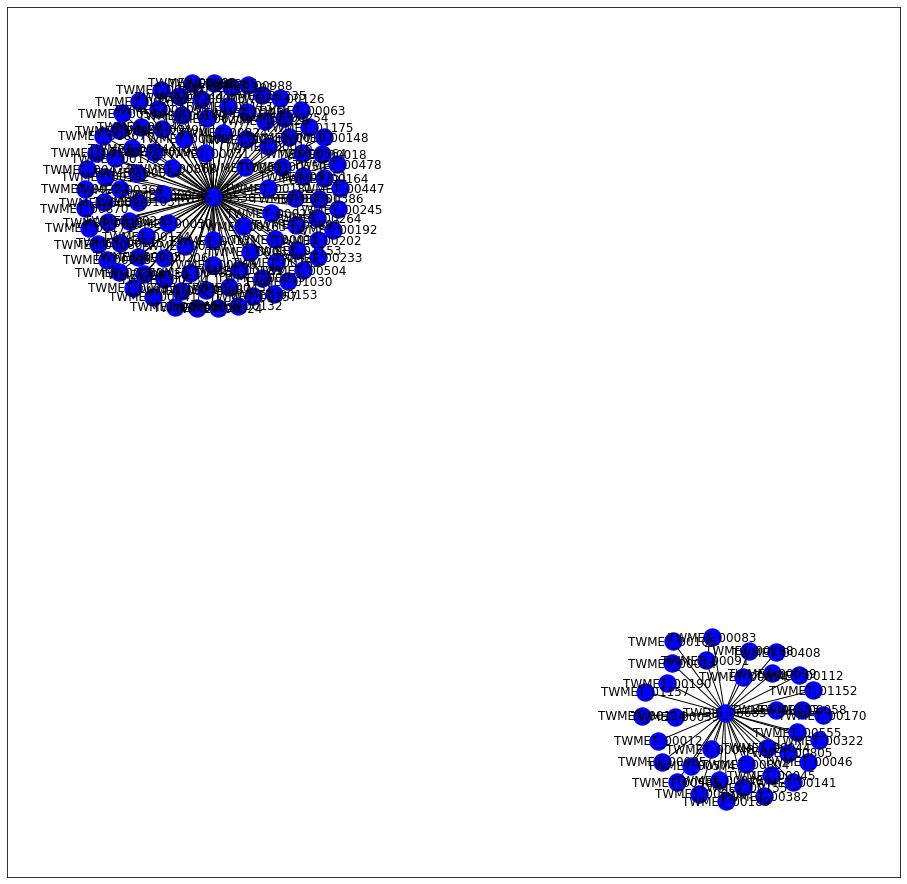

In [4]:
g = nx.from_pandas_edgelist(full_df, source='subject',
                            target='object', edge_attr='local_mi', edge_key='local_mi')
plt.figure(5, figsize=(16, 16))
pos =nx.spring_layout(g)
nx.draw_networkx(g, node_color="blue" , pos=pos, with_labels = True)


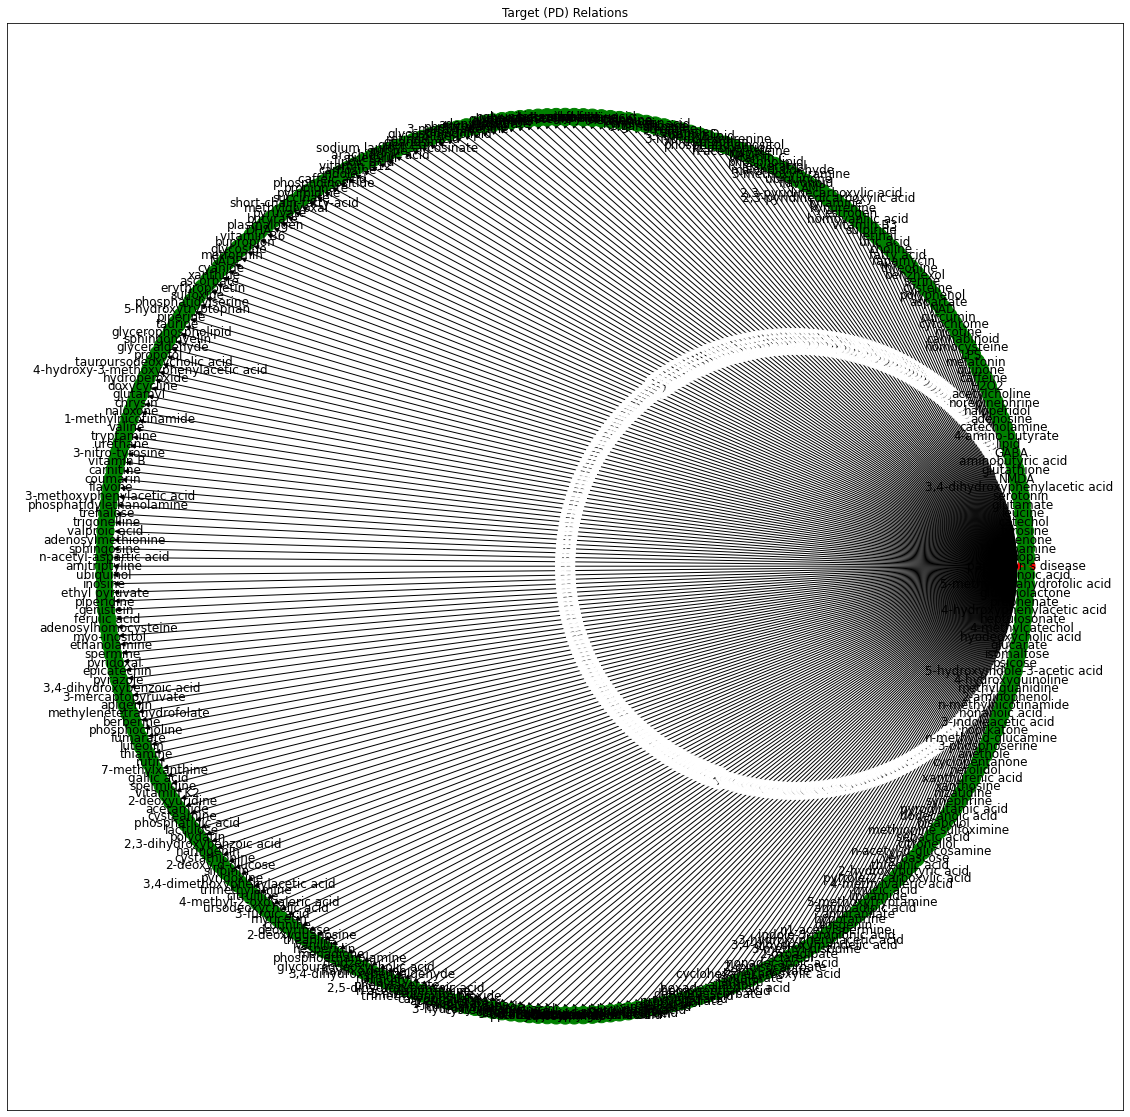

In [5]:
# convert positive parkinsons relations to graph
df_park = pd.read_csv('/homes/fabadmus/Internship/PDtest2/TWDIS_06685', sep='\t')
g = nx.from_pandas_edgelist(df_park, "subject_annotated", "object_annotated", 'local_mi',
                            create_using=nx.DiGraph)
# plot the graph
plt.figure(10, figsize=(20, 20))
pos = nx.spring_layout(g, weight='local_mi', iterations=200)
pos = nx.circular_layout(g)
color_map = ['red' if node.startswith("park") else 'green' for node in g.nodes] 
nx.draw_networkx(g, node_color=color_map , pos=pos)
nx.draw_networkx_edge_labels(g, 
pos=pos, 
edge_labels=nx.get_edge_attributes(g, 'local_mi'),
font_color="black",
);
plt.title('Target (PD) Relations')
plt.show()

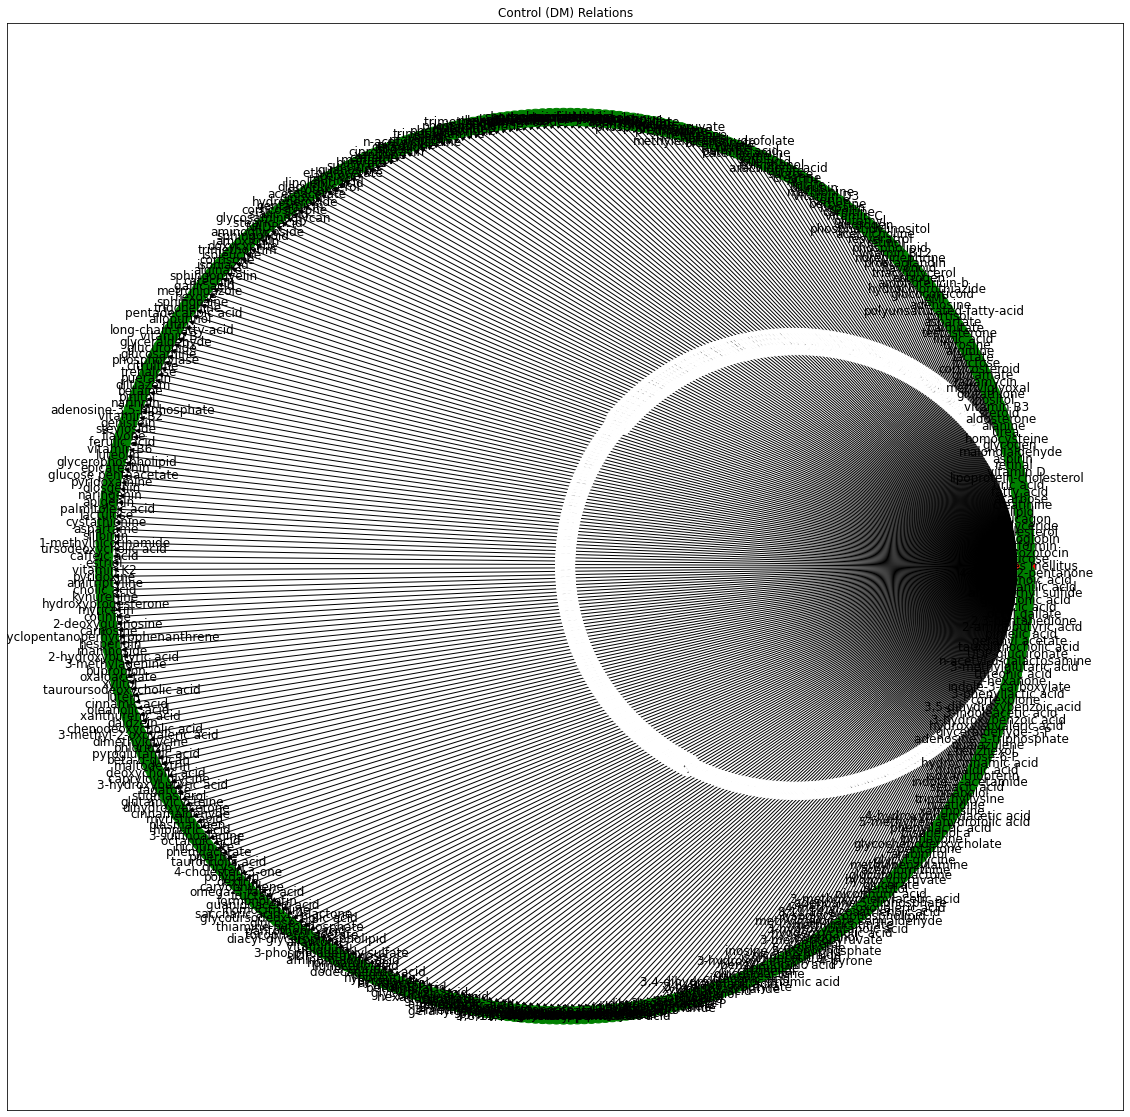

In [6]:
# convert positive parkinsons relations to graph
df_park = pd.read_csv('/homes/fabadmus/Internship/PDtest2/TWDIS_09536', sep='\t')
g = nx.from_pandas_edgelist(df_park, "subject_annotated", "object_annotated", 'local_mi',
                            create_using=nx.DiGraph)
# plot the graph
plt.figure(10, figsize=(20, 20))
pos = nx.spring_layout(g, weight='local_mi', iterations=200)
pos = nx.circular_layout(g)
color_map = ['red' if node.startswith("diab") else 'green' for node in g.nodes] 
nx.draw_networkx(g, node_color=color_map , pos=pos)
nx.draw_networkx_edge_labels(g, 
pos=pos, 
edge_labels=nx.get_edge_attributes(g, 'local_mi'),
font_color="black",
);
plt.title('Control (DM) Relations')
plt.show()

In [7]:
second_layer = pd.read_csv('/homes/fabadmus/Internship/PD/second_layer')
second_layer

Unnamed: 0      subject       object  local_mi
0              0  TWDIS_06685  TWMET_00170   1341760
1              1  TWDIS_06685  TWMET_00012    573717
2              2  TWDIS_06685  TWMET_01157     86022
3              3  TWDIS_06685  TWMET_00848     11973
4              4  TWDIS_06685  TWMET_00014      5049
...          ...          ...          ...       ...
2508        2508  TWMET_01236  TWMET_01125     78449
2509        2509  TWMET_01237  TWMET_00708    220230
2510        2510  TWMET_01237  TWMET_00748     89712
2511        2511  TWMET_01238  TWMET_00680   4408950
2512        2512  TWMET_01238  TWMET_00053     46512

[2513 rows x 4 columns]

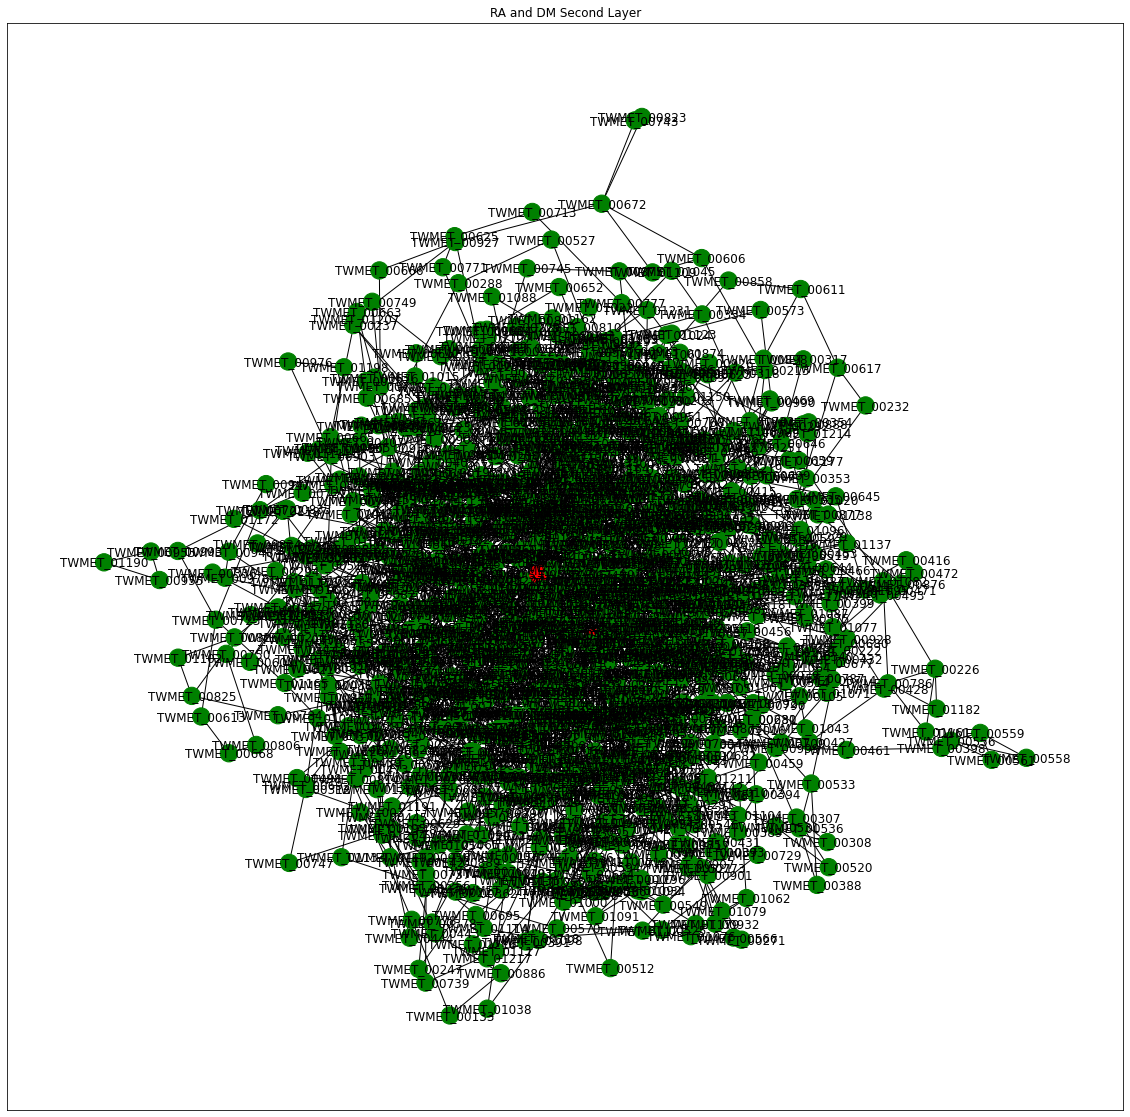

In [8]:
full_second_layer = pd.read_csv('/homes/fabadmus/Internship/PD/second_layer')
g = nx.from_pandas_edgelist(full_second_layer, source='subject',
                            target='object')
# plot the graph
plt.figure(10, figsize=(20, 20))
pos = nx.spring_layout(g, weight='local_mi', iterations=10)

#pos = nx.nx_agraph.graphviz_layout(g, prog="twopi", args="")
# test[test == '0'] = '#C6442A'
# test[test == '1'] = '#9E2AC6'
color_map = ['red' if node.startswith("TWDIS") else 'green' for node in g.nodes] 
nx.draw_networkx(g, node_color=color_map , pos=pos)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=nx.get_edge_attributes(g, 'local_mi'), font_color="black",
);
plt.title('RA and DM Second Layer')
plt.show()

In [9]:
# convert the second_layer into a graph
second_layer = second_layer[second_layer.subject.str.startswith('TWDIS') == False]
G = nx.from_pandas_edgelist(second_layer, source='subject',
                            target='object', edge_attr='local_mi', edge_key='local_mi')

In [10]:
# load the embeddings of the graph


embeddings = Word2Vec.load('/homes/fabadmus/Internship/PD/embedding')

# Convert embeddings to dataframe

emb_df = (pd.DataFrame([embeddings.wv.get_vector(str(n))

                        for n in G.nodes], index=G.nodes))

#emb_df = (pd.DataFrame([embeddings.wv.get_vector]))

emb_df.head(10)

0         1         2         3         4         5   \
TWMET_00001  0.902957 -0.778320  0.539384 -2.705285 -5.306027  3.274118   
TWMET_00011 -0.192634 -1.939560  0.484096 -0.043149 -3.687867  0.700474   
TWMET_00411  1.035362 -0.709528 -0.219280 -1.228460 -2.002434  1.347786   
TWMET_00002 -1.692194 -1.372930  1.355375 -0.026295 -2.008363  1.523438   
TWMET_00003 -0.516895 -0.842043  2.057472  0.359578 -2.690099  2.127578   
TWMET_00004 -1.011824  4.233769 -1.433056 -1.946595  1.951116  3.231214   
TWMET_00144  0.023826  4.676752 -4.188200 -2.545005  0.437831  1.772273   
TWMET_00126  1.382663  3.116126 -1.690515 -1.840758  3.646607  3.207673   
TWMET_00005 -1.173321 -0.344729  0.966166  0.168159 -1.537142 -1.553545   
TWMET_00026 -1.263662 -1.750343  0.793675  0.138565 -2.828912 -0.513072   

                   6         7         8         9         10        11  \
TWMET_00001  1.409320 -0.117757 -0.317571 -2.192573 -5.669549  1.216383   
TWMET_00011  2.503553 -2.948092  0.644898  1.816902 -3.534233  1.279026   
TWMET_00411 -0.001485 -0.076340 -0.778858  0.353300 -2.309604  0.303137   
TWMET_00002  0.579625 -3.717765  2.260972  0.936523 -3.019620  0.850970   
TWMET_00003  1.014004 -3.994218  2.046385  1.610928 -4.376371  0.624957   
TWMET_00004 -4.807255  1.172205  0.204556  0.387075 -3.633836  0.601095   
TWMET_00144 -3.102679  1.032383  0.084488  1.467750 -4.225349  2.748734   
TWMET_00126 -3.566455  2.401571  0.291001  2.743359 -1.436403 -1.570861   
TWMET_00005  0.540652 -0.600209 -1.913221  3.069814 -0.886453 -1.876066   
TWMET_00026 -0.587721  0.601066 -2.819690  4.377004 -1.813077 -2.847085   

                   12        13        14        15  
TWMET_00001  5.877940 -3.460925  3.340271 -3.302987  
TWMET_00011  1.735811 -2.817909  4.524133 -2.501109  
TWMET_00411  2.484560 -1.770919  1.561385 -0.696836  
TWMET_00002  1.513899 -2.248860  4.106234 -1.467438  
TWMET_00003  1.636471 -3.352240  3.763919 -3.462848  
TWMET_00004  3.409060 -1.941670  3.886697 -2.094642  
TWMET_00144  3.189529 -0.414556  3.083435 -1.351253  
TWMET_00126  3.993860 -0.326934  2.450101 -1.741414  
TWMET_00005 -2.015217 -0.593224  2.538409  2.400727  
TWMET_00026 -3.613550 -2.491869  2.603974  2.895120

In [11]:
# get set of positive and negative concepts from the full data
pos = set(full_df[full_df['label'] == 'POS'].object)
neg = set(full_df[full_df['label'] == 'NEG'].object)

In [12]:
len(emb_df.loc[emb_df.index.isin(pos)])

35

In [13]:
emb_df.loc[emb_df.index.isin(pos), 'SET'] = 'POS'
emb_df.loc[emb_df.index.isin(neg), 'SET'] = 'NEG'
emb_df.loc[emb_df.SET.isnull(), 'SET'] = 'UNK'

In [14]:
len(emb_df.loc[emb_df.SET == 'UNK'])

1061

In [15]:
len(emb_df.loc[emb_df.SET == 'POS'])

35

In [16]:
len(emb_df.loc[emb_df.SET == 'NEG'])

100

In [52]:
emb_df.loc[emb_df.SET == 'UNK']

0         1         2         3         4         5  \
TWMET_00411  1.035362 -0.709528 -0.219280 -1.228460 -2.002434  1.347786   
TWMET_00002 -1.692194 -1.372930  1.355375 -0.026295 -2.008363  1.523438   
TWMET_00004 -1.011824  4.233769 -1.433056 -1.946595  1.951116  3.231214   
TWMET_00144  0.023826  4.676752 -4.188200 -2.545005  0.437831  1.772273   
TWMET_00026 -1.263662 -1.750343  0.793675  0.138565 -2.828912 -0.513072   
...               ...       ...       ...       ...       ...       ...   
TWMET_01218  0.016260  0.383561 -0.064179  0.109632 -0.198558  0.049238   
TWMET_01222 -0.128490  0.230739 -0.037039  0.049145 -0.148278  0.206249   
TWMET_01223 -0.009530 -0.079156 -0.033000 -0.013934  0.021170 -0.078787   
TWMET_01230 -0.006125 -0.139554 -0.196890 -0.295201 -0.166312 -0.003433   
TWMET_01231  0.459902  0.244335 -0.085273 -0.004885 -0.227239  0.677643   

                    6         7         8         9        10        11  \
TWMET_00411 -0.001485 -0.076340 -0.778858  0.353300 -2.309604  0.303137   
TWMET_00002  0.579625 -3.717765  2.260972  0.936523 -3.019620  0.850970   
TWMET_00004 -4.807255  1.172205  0.204556  0.387075 -3.633836  0.601095   
TWMET_00144 -3.102679  1.032383  0.084488  1.467750 -4.225349  2.748734   
TWMET_00026 -0.587721  0.601066 -2.819690  4.377004 -1.813077 -2.847085   
...               ...       ...       ...       ...       ...       ...   
TWMET_01218 -0.064278 -0.188686 -0.210641  0.387851 -0.219247  0.323541   
TWMET_01222  0.068276  0.055207  0.130947  0.114731 -0.114535  0.095401   
TWMET_01223  0.078708 -0.243728 -0.003864 -0.019122 -0.077292 -0.095761   
TWMET_01230  0.299075  0.205720  0.253520  0.252580 -0.373069  0.110047   
TWMET_01231 -0.037968 -0.849479 -0.370413  0.494430  0.439036 -0.222684   

                   12        13        14        15  SET  
TWMET_00411  2.484560 -1.770919  1.561385 -0.696836  UNK  
TWMET_00002  1.513899 -2.248860  4.106234 -1.467438  UNK  
TWMET_00004  3.409060 -1.941670  3.886697 -2.094642  UNK  
TWMET_00144  3.189529 -0.414556  3.083435 -1.351253  UNK  
TWMET_00026 -3.613550 -2.491869  2.603974  2.895120  UNK  
...               ...       ...       ...       ...  ...  
TWMET_01218 -0.163230 -0.402726  0.263920  0.008415  UNK  
TWMET_01222 -0.022857 -0.127025  0.039954  0.055664  UNK  
TWMET_01223  0.034667 -0.244887 -0.046636  0.135369  UNK  
TWMET_01230 -0.168389 -0.012123  0.180268  0.384071  UNK  
TWMET_01231  0.554661 -0.177581  0.621358  0.384235  UNK  

[1061 rows x 17 columns]

In [17]:
model_df = emb_df.loc[(emb_df.SET == 'POS') | (emb_df.SET == 'NEG')]
#training_embs.tail(50)

In [53]:
# # create separate dataframes of embeddings bases on the sets
# emb_df_pos = emb_df[emb_df.index.isin(pos)]
# emb_df_pos['set'] = 'POS'
# emb_df_neg = emb_df[emb_df.index.isin(neg)]
# emb_df_neg['set'] = 'NEG'

In [29]:
# inspecting
print(len(emb_df_pos))
print(len(emb_df_neg))

35
100


In [18]:
# create a dataframe for the training from the labeled embeddings
# model_df = pd.concat([emb_df_pos, emb_df_neg])
model_df.head()

0         1         2         3         4         5  \
TWMET_00001  0.902957 -0.778320  0.539384 -2.705285 -5.306027  3.274118   
TWMET_00011 -0.192634 -1.939560  0.484096 -0.043149 -3.687867  0.700474   
TWMET_00003 -0.516895 -0.842043  2.057472  0.359578 -2.690099  2.127578   
TWMET_00126  1.382663  3.116126 -1.690515 -1.840758  3.646607  3.207673   
TWMET_00005 -1.173321 -0.344729  0.966166  0.168159 -1.537142 -1.553545   

                    6         7         8         9        10        11  \
TWMET_00001  1.409320 -0.117757 -0.317571 -2.192573 -5.669549  1.216383   
TWMET_00011  2.503553 -2.948092  0.644898  1.816902 -3.534233  1.279026   
TWMET_00003  1.014004 -3.994218  2.046385  1.610928 -4.376371  0.624957   
TWMET_00126 -3.566455  2.401571  0.291001  2.743359 -1.436403 -1.570861   
TWMET_00005  0.540652 -0.600209 -1.913221  3.069814 -0.886453 -1.876066   

                   12        13        14        15  SET  
TWMET_00001  5.877940 -3.460925  3.340271 -3.302987  NEG  
TWMET_00011  1.735811 -2.817909  4.524133 -2.501109  NEG  
TWMET_00003  1.636471 -3.352240  3.763919 -3.462848  NEG  
TWMET_00126  3.993860 -0.326934  2.450101 -1.741414  NEG  
TWMET_00005 -2.015217 -0.593224  2.538409  2.400727  NEG

In [58]:
# create validation data from the embedding data
# validation_df = pd.concat([emb_df_pos, emb_df_neg, emb_df]).drop_duplicates(
#     subset=emb_df.columns[:-1], keep=False)
validation_df = emb_df.loc[emb_df.SET == 'UNK']
validation_df.head()

0         1         2         3         4         5  \
TWMET_00411  1.035362 -0.709528 -0.219280 -1.228460 -2.002434  1.347786   
TWMET_00002 -1.692194 -1.372930  1.355375 -0.026295 -2.008363  1.523438   
TWMET_00004 -1.011824  4.233769 -1.433056 -1.946595  1.951116  3.231214   
TWMET_00144  0.023826  4.676752 -4.188200 -2.545005  0.437831  1.772273   
TWMET_00026 -1.263662 -1.750343  0.793675  0.138565 -2.828912 -0.513072   

                    6         7         8         9        10        11  \
TWMET_00411 -0.001485 -0.076340 -0.778858  0.353300 -2.309604  0.303137   
TWMET_00002  0.579625 -3.717765  2.260972  0.936523 -3.019620  0.850970   
TWMET_00004 -4.807255  1.172205  0.204556  0.387075 -3.633836  0.601095   
TWMET_00144 -3.102679  1.032383  0.084488  1.467750 -4.225349  2.748734   
TWMET_00026 -0.587721  0.601066 -2.819690  4.377004 -1.813077 -2.847085   

                   12        13        14        15  SET  
TWMET_00411  2.484560 -1.770919  1.561385 -0.696836  UNK  
TWMET_00002  1.513899 -2.248860  4.106234 -1.467438  UNK  
TWMET_00004  3.409060 -1.941670  3.886697 -2.094642  UNK  
TWMET_00144  3.189529 -0.414556  3.083435 -1.351253  UNK  
TWMET_00026 -3.613550 -2.491869  2.603974  2.895120  UNK

In [21]:
print(len(model_df))

135


In [20]:
# assign the independent and dependent variables
X = model_df.iloc[:,:-1].values
y = model_df['SET']

In [22]:
import lazypredict
from lazypredict.Supervised import LazyClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3,random_state =123)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 29/29 [00:01<00:00, 18.22it/s]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
NuSVC                              0.93               0.83    None      0.92   
QuadraticDiscriminantAnalysis      0.88               0.80    None      0.88   
GaussianNB                         0.78               0.78    None      0.80   
SVC                                0.90               0.78    None      0.89   
NearestCentroid                    0.71               0.77    None      0.73   
Perceptron                         0.73               0.75    None      0.75   
RidgeClassifierCV                  0.83               0.73    None      0.83   
RidgeClassifier                    0.83               0.73    None      0.83   
PassiveAggressiveClassifier        0.76               0.72    None      0.77   
LinearDiscriminantAnalysis         0.80               0.72    None      0.80   
ExtraTreesClassifier               0.85 

## ADABOOST

In [17]:
from sklearn.ensemble import AdaBoostClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3,random_state =123)
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7804878048780488


In [23]:
# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42) 

In [24]:
param_grid = {'min_samples_leaf':[3,5,7,10,15],'max_features':[0.5,'sqrt','log2'],
          'max_depth':[10,15,20],
          'class_weight':[{"POS":3,"NEG":1},{"POS":1,"NEG":1}],
          'criterion':['entropy','gini']}


model1 = GridSearchCV(RandomForestClassifier(),param_grid, verbose=1,n_jobs=-1,scoring='roc_auc')
model1.fit(X_train,y_train)
print ('\n',model1.best_estimator_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits

 RandomForestClassifier(class_weight={'NEG': 1, 'POS': 3}, criterion='entropy',
                       max_depth=10, max_features='log2', min_samples_leaf=5)


In [25]:
pred1 = model1.predict(X_test)
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

         NEG       0.74      0.93      0.83        28
         POS       0.67      0.31      0.42        13

    accuracy                           0.73        41
   macro avg       0.70      0.62      0.62        41
weighted avg       0.72      0.73      0.70        41



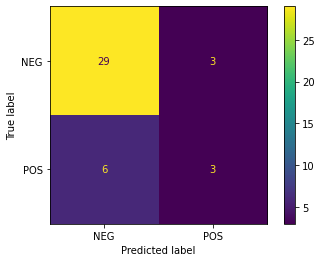

In [66]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model1, X_test, y_test)
plt.show()

/commons/conda/firdaws_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


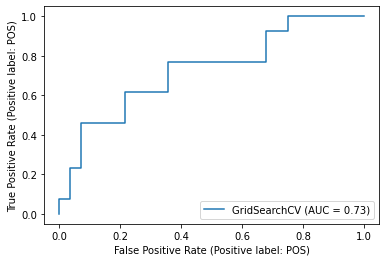

In [68]:
metrics.plot_roc_curve(model1, X_test, y_test)

In [67]:
model2 = RandomForestClassifier()

model2.fit(X_train, y_train)

RandomForestClassifier()

In [68]:
pred2 = model2.predict(X_test)
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

         NEG       0.88      0.94      0.91        32
         POS       0.71      0.56      0.63         9

    accuracy                           0.85        41
   macro avg       0.80      0.75      0.77        41
weighted avg       0.85      0.85      0.85        41



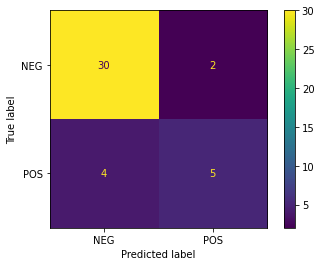

In [69]:
plot_confusion_matrix(model2, X_test, y_test)
plt.show()

/commons/conda/firdaws_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


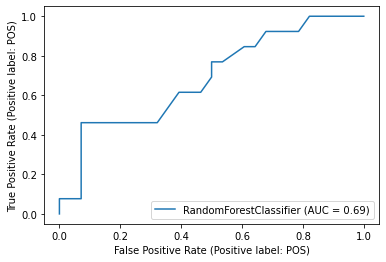

In [72]:
metrics.plot_roc_curve(model2, X_test, y_test)

In [26]:
# make predictions on the unknown
#X_val = validation_df.iloc[:,:-1]
X_val = emb_df.iloc[:,:-1]
pred = model1.predict(X_val)

In [27]:
val_proba = model1.predict_proba(X_val)

In [28]:
# convert predictions and actual values to dataframe
val_proba_df = pd.DataFrame(val_proba, index=X_val.index,
                                columns=['NEG_prob', 'POS_prob'])
val_proba_df['predictions'] = pred
val_proba_df = val_proba_df.sort_values('POS_prob', ascending=False)
val_proba_df

NEG_prob  POS_prob predictions
TWMET_00170      0.14      0.86         POS
TWMET_00155      0.20      0.80         POS
TWMET_00190      0.22      0.78         POS
TWMET_00166      0.22      0.78         POS
TWMET_00848      0.23      0.77         POS
...               ...       ...         ...
TWMET_00435      0.94      0.06         NEG
TWMET_00931      0.95      0.05         NEG
TWMET_00055      0.96      0.04         NEG
TWMET_00131      0.96      0.04         NEG
TWMET_00157      0.96      0.04         NEG

[1196 rows x 3 columns]

In [29]:
val_proba_df.index.names = ['ID']

In [30]:
emb_df.index.names = ['ID']


In [106]:
emb_df

0     1     2     3     4     5     6     7     8     9    10  \
ID                                                                              
TWMET_00001  0.90 -0.78  0.54 -2.71 -5.31  3.27  1.41 -0.12 -0.32 -2.19 -5.67   
TWMET_00011 -0.19 -1.94  0.48 -0.04 -3.69  0.70  2.50 -2.95  0.64  1.82 -3.53   
TWMET_00411  1.04 -0.71 -0.22 -1.23 -2.00  1.35 -0.00 -0.08 -0.78  0.35 -2.31   
TWMET_00002 -1.69 -1.37  1.36 -0.03 -2.01  1.52  0.58 -3.72  2.26  0.94 -3.02   
TWMET_00003 -0.52 -0.84  2.06  0.36 -2.69  2.13  1.01 -3.99  2.05  1.61 -4.38   
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
TWMET_01218  0.02  0.38 -0.06  0.11 -0.20  0.05 -0.06 -0.19 -0.21  0.39 -0.22   
TWMET_01222 -0.13  0.23 -0.04  0.05 -0.15  0.21  0.07  0.06  0.13  0.11 -0.11   
TWMET_01223 -0.01 -0.08 -0.03 -0.01  0.02 -0.08  0.08 -0.24 -0.00 -0.02 -0.08   
TWMET_01230 -0.01 -0.14 -0.20 -0.30 -0.17 -0.00  0.30  0.21  0.25  0.25 -0.37   
TWMET_01231  0.46  0.24 -0.09 -0.00 -0.23  0.68 -0.04 -0.85 -0.37  0.49  0.44   

               11    12    13    14    15  SET  
ID                                              
TWMET_00001  1.22  5.88 -3.46  3.34 -3.30  NEG  
TWMET_00011  1.28  1.74 -2.82  4.52 -2.50  NEG  
TWMET_00411  0.30  2.48 -1.77  1.56 -0.70  UNK  
TWMET_00002  0.85  1.51 -2.25  4.11 -1.47  UNK  
TWMET_00003  0.62  1.64 -3.35  3.76 -3.46  NEG  
...           ...   ...   ...   ...   ...  ...  
TWMET_01218  0.32 -0.16 -0.40  0.26  0.01  UNK  
TWMET_01222  0.10 -0.02 -0.13  0.04  0.06  UNK  
TWMET_01223 -0.10  0.03 -0.24 -0.05  0.14  UNK  
TWMET_01230  0.11 -0.17 -0.01  0.18  0.38  UNK  
TWMET_01231 -0.22  0.55 -0.18  0.62  0.38  UNK  

[1196 rows x 17 columns]

In [34]:
# sourcery skip: avoid-builtin-shadow
predictions_df = pd.merge(emb_df['SET'],val_proba_df, how = 'left', on = 'ID')
predictions_df

SET  NEG_prob  POS_prob predictions
ID                                              
TWMET_00001  NEG      0.91      0.09         NEG
TWMET_00011  NEG      0.91      0.09         NEG
TWMET_00411  UNK      0.90      0.10         NEG
TWMET_00002  UNK      0.88      0.12         NEG
TWMET_00003  NEG      0.89      0.11         NEG
...          ...       ...       ...         ...
TWMET_01218  UNK      0.57      0.43         NEG
TWMET_01222  UNK      0.57      0.43         NEG
TWMET_01223  UNK      0.56      0.44         NEG
TWMET_01230  UNK      0.57      0.43         NEG
TWMET_01231  UNK      0.71      0.29         NEG

[1196 rows x 4 columns]

In [38]:
len(predictions_df.index)

1196

In [40]:
session = requests.Session()
base_url = 'https://apimlqv2.tenwiseservice.nl/api/mlquery/'
session.headers['referer'] = 'https://apimlqv2.tenwiseservice.nl'
session.get(f"{base_url}start/")

payload = {'apikey': '',
           'csrfmiddlewaretoken': session.cookies.get_dict()['csrftoken']}

# annotate predictions
ids = list(predictions_df.index)
payload['concept_ids'] = ",".join(ids)
results = session.post(f"{base_url}conceptset/annotation/", payload)
js = results.json()
annotation = js['result']['annotation']
# get ids
annotated_ids = []
for id in ids:
    annotated_ids.extend(annotation[id]['name'])
# add ids to the dataframe
predictions_df['annotation'] = annotated_ids
predictions_df = predictions_df.sort_values('POS_prob', ascending=False)
predictions_df.head(10)

SET  NEG_prob  POS_prob predictions         annotation
ID                                                                 
TWMET_00170  POS      0.14      0.86         POS               dopa
TWMET_00155  POS      0.20      0.80         POS        cannabinoid
TWMET_00190  POS      0.22      0.78         POS            quinone
TWMET_00166  POS      0.22      0.78         POS        haloperidol
TWMET_00848  POS      0.23      0.77         POS           catechol
TWMET_00805  POS      0.23      0.77         POS  aminobutyric acid
TWMET_00322  POS      0.24      0.76         POS   4-amino-butyrate
TWMET_00754  UNK      0.24      0.76         POS   4-methylcatechol
TWMET_01184  UNK      0.25      0.75         POS          sulpiride
TWMET_00058  POS      0.26      0.74         POS               GABA

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np


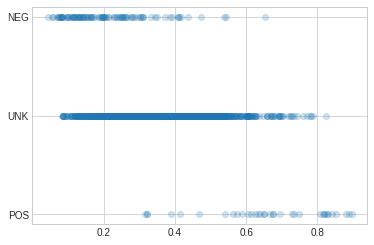

In [140]:
plt.scatter(predictions.POS_prob, predictions.SET, alpha=0.2, cmap='viridis')

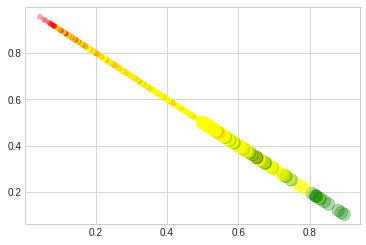

In [152]:
colors = {"POS":'green', "NEG":'red', "UNK":'yellow'}
sizes = {"POS":150, "NEG":20}
plt.scatter(predictions.POS_prob, predictions.NEG_prob, c=predictions.SET.map(colors), s=predictions.predictions.map(sizes),alpha=0.3, cmap='viridis')

(array([ 56., 162., 225., 222., 237., 181.,  61.,  28.,  13.,  11.]),
 array([0.0432594 , 0.12863694, 0.21401447, 0.29939201, 0.38476955,
        0.47014708, 0.55552462, 0.64090216, 0.72627969, 0.81165723,
        0.89703477]),
 <BarContainer object of 10 artists>)

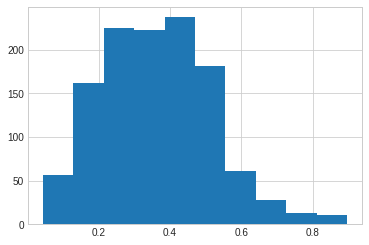

In [136]:
colors = {"POS":'green', "NEG":'red', "UNK":'yellow'}
plt.hist(
    predictions.POS_prob,
    label=predictions.predictions,

)